Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



C:\Users\JohnnyHu\Anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


1999 0.6499999761581421 0.46000000834465027


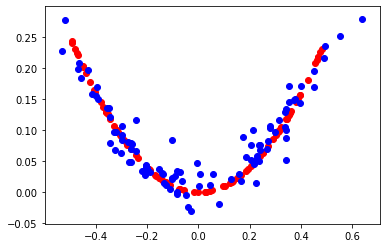

3999 0.47999998927116394 0.6700000166893005


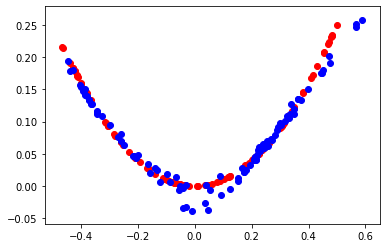

5999 0.8199999928474426 0.33000001311302185


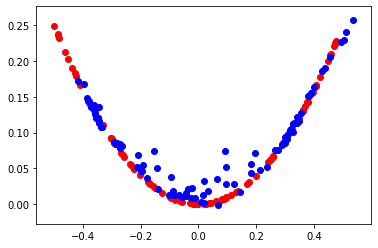

7999 0.550000011920929 0.7599999904632568


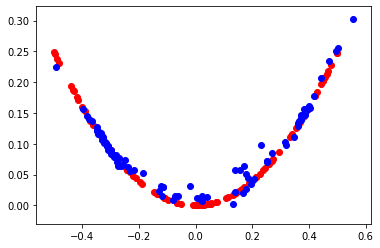

9999 0.5 0.699999988079071


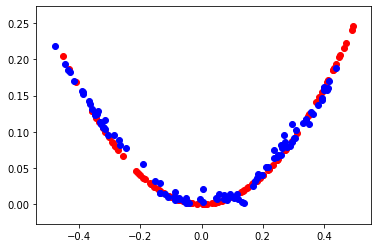

In [3]:
from numpy import hstack
from numpy import zeros
from numpy import ones
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot

def define_discriminator(n_inputs=2):
    model = Sequential()
    model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
    model.add(Dense(1, activation='sigmoid'))
    # 編譯模型
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model
    # 定義獨立的生成器模型
def define_generator(latent_dim, n_outputs=2):
    model = Sequential()
    model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
    model.add(Dense(n_outputs, activation='linear'))
    return model
# 定義合併的生成器和判別器模型，來更新生成器
def define_gan(generator, discriminator):
    # 將判別器的權重設為不可訓練
    discriminator.trainable = False
    # 連接它們
    model = Sequential()
    # 加入生成器
    model.add(generator)
    # 加入判別器
    model.add(discriminator)
    # 編譯模型
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model
# 生成 n 個真實樣本和類標籤
def generate_real_samples(n):
    # 生成 [-0.5, 0.5] 範圍內的輸入值
    X1 = rand(n) - 0.5
    # 生成輸出值 X^2
    X2 = X1 * X1
    # 堆疊數組
    X1 = X1.reshape(n, 1)
    X2 = X2.reshape(n, 1)
    X = hstack((X1, X2))
    # 生成類標籤
    y = ones((n, 1))
    return X, y
    # 生成隱空間中的點作為生成器的輸入
def generate_latent_points(latent_dim, n):
    # 在隱空間中生成點
    x_input = randn(latent_dim * n)
    # 為網絡調整一個 batch 輸入的維度大小
    x_input = x_input.reshape(n, latent_dim)
    return x_input
    # 用生成器生成 n 個假樣本和類標籤
def generate_fake_samples(generator, latent_dim, n):
    # 在隱空間中生成點
    x_input = generate_latent_points(latent_dim, n)
    # 預測輸出值
    X = generator.predict(x_input)
    # 創建類標籤
    y = zeros((n, 1))
    return X, y
    # 評估判別器並且繪製真假點
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
    # 準備真實樣本
    x_real, y_real = generate_real_samples(n)
    # 在真實樣本上評估判別器
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    # 準備假樣本
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    # 在假樣本上評估判別器
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    # 總結判別器性能
    print(epoch, acc_real, acc_fake)
    # 繪製真假數據的散點圖
    pyplot.scatter(x_real[:, 0], x_real[:, 1], color='red')
    pyplot.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
    pyplot.show()
    # 訓練生成器和判別器
def train(g_model, d_model, gan_model, latent_dim, n_epochs=1000, n_batch=128, n_eval=200):
    # 用一半的 batch 數量來訓練判別器
    half_batch = int(n_batch / 2)
    # 手動遍歷 epoch
    for i in range(n_epochs):
        # 準備真實樣本
        x_real, y_real = generate_real_samples(half_batch)
        # 準備假樣本
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
        for j in range(10):
            # 更新判別器
            d_model.train_on_batch(x_real, y_real)
            d_model.train_on_batch(x_fake, y_fake)
        for j in range(10):
            # 在隱空間中準備點作為生成器的輸入
            x_gan = generate_latent_points(latent_dim, n_batch)
            # 為假樣本創建反標籤
            y_gan = ones((n_batch, 1))
            # 通過判別器的誤差更新生成器
            gan_model.train_on_batch(x_gan, y_gan)
        # 為每 n_eval epoch 模型做評估
        if (i+1) % n_eval == 0:
            summarize_performance(i, g_model, d_model, latent_dim)
            # 隱空間的維度
latent_dim = 5
# 創建判別器
discriminator = define_discriminator()
# 創建生成器
generator = define_generator(latent_dim)
# 創建生成對抗網絡
gan_model = define_gan(generator, discriminator)
# 訓練模型
train(generator, discriminator, gan_model, latent_dim)